<a href="https://colab.research.google.com/github/rajivgaba/book-recommendation-chatbot/blob/main/book_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ! pip install kagglehub
# ! python3 -m pip install --upgrade pip
# ! pip install openai

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abdallahwagih/books-dataset")

print("Path to dataset files:", path)

/Users/RajivGaba/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Path to dataset files: /Users/RajivGaba/.cache/kagglehub/datasets/abdallahwagih/books-dataset/versions/1


In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from openai import OpenAI
import json

In [4]:
for file in os.listdir(path):
    print(file)

df = pd.read_csv(path + "/data.csv" )
df.head()

data.csv
intents.json


,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0
2,9780006163831,0006163831,The One Tree,NaN,Stephen R. Donaldson,American fiction,http://books.google.com/books/content?id=OmQaw...,Volume Two of Stephen Donaldson's acclaimed se...,1982.0,3.97,479.0,172.0
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6810 entries, 0 to 6809
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   isbn13          6810 non-null   int64  
 1   isbn10          6810 non-null   object 
 2   title           6810 non-null   object 
 3   subtitle        2381 non-null   object 
 4   authors         6738 non-null   object 
 5   categories      6711 non-null   object 
 6   thumbnail       6481 non-null   object 
 7   description     6548 non-null   object 
 8   published_year  6804 non-null   float64
 9   average_rating  6767 non-null   float64
 10  num_pages       6767 non-null   float64
 11  ratings_count   6767 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 638.6+ KB


In [6]:
df['categories'].value_counts().head(20)

categories
Fiction                      2588
Juvenile Fiction              538
Biography & Autobiography     401
History                       264
Literary Criticism            166
Philosophy                    160
Comics & Graphic Novels       159
Religion                      137
Drama                         132
Juvenile Nonfiction           116
Poetry                         79
Science                        71
Literary Collections           71
Business & Economics           67
Social Science                 60
Performing Arts                50
Cooking                        47
Art                            46
Body, Mind & Spirit            44
Travel                         43
Name: count, dtype: int64

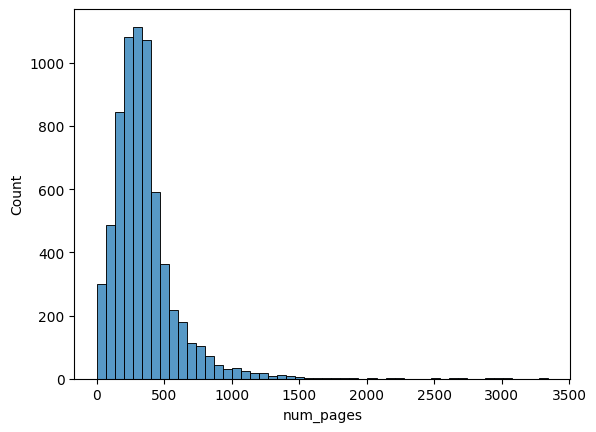

In [7]:
# print the num_pages and ratings_count on bar charts

plt.figure()
sns.histplot(x=df['num_pages'], bins=50)
plt.show()

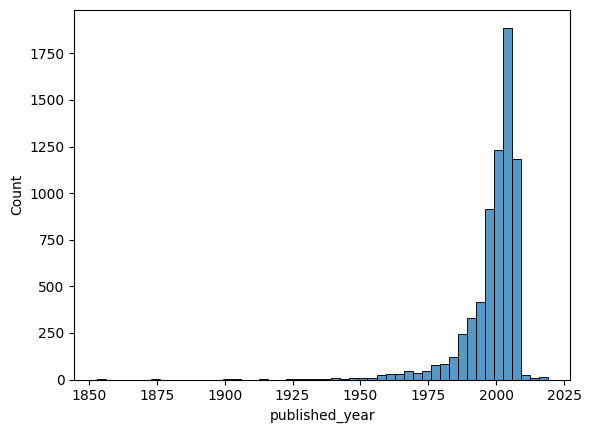

In [8]:
plt.figure()
sns.histplot(x=df['published_year'], bins=50)
plt.show()

In [9]:
try:
    from google.colab import userdata
    pplx_key = userdata.get('PREPLEXITY_API_KEY')
    openai_key = userdata.get('OPENAI_KEY')
    print("keys imported from Google Colab userdata")
except:
    import dotenv
    from dotenv import load_dotenv
    import os
    load_dotenv()
    pplx_key = os.getenv('PREPLEXITY_API_KEY')
    openai_key = os.getenv('OPENAI_API_KEY')
    print("keys imported from local .env file")

keys imported from local .env file


In [10]:
def initialize_conversation():
  delimiter = "####"
  example_user_dict = {
      'categories' : 'history',
      'book size' : 'long',
      'author' : 'sidney sheldon',
      'title' : '_',
      'book age' : '_'
  }

  system_message = f"""
  You are an expert academic and an avid reader. Your task is to recommend books to the user.
  You need to get inputs from the user, understand their need to what kind of book they want to read and capture
  information in python dictionary. The dicitonary would look like this:
  {{
      'categories' : 'values',
      'book size' : 'values',
      'author' : 'values',
      'title' : 'values',
      'book age' : 'values'
  }}
  {delimiter}

  Here are some instructions around the values of these keys.
  - 'book size' should strictly be 'small', 'medium' and 'large'
  - 'book age' should strictly be 'new', 'old' and 'very old'
  - 'categories' should be one of the genres like history, fiction, non-fiction, science, etc. 
  - User may not have any preference for title or book age. In that case, you can fill the value as 'No Preference'

  {delimiter}

  To fill the dictionary, you need to have following chain of thoughts:

  {delimiter}
  Thought 1: Ask a question to the user about what kind of book they want to read. Try and understand the genre \n
  or category of the book. Also, ask if they have any preference for any author or book title or how big the book should \n
  be or how old the book should be. Identify the keys for which you can fill the values confidently using the understanding \n

  {delimiter}
  Thought 2: Now, you are trying to fill the values for the rest of the keys which you couldn't in the previous step. \n
  Remember the instructions around the values for the different keys. Ask questions you might have for all the keys to \n
  strengthen your understanding of the user's profile. If yes, move to the next Thought. If no, ask question on the keys \n
  whose values you are unsure of. It is a good practice to ask question with a sound logic as opposed to directly citing \n
  the key you want to understand value for.
  {delimiter}

  {delimiter}
  Thought 3: Check if you have correctly updated the values for the different keys in the python dictionary.
  If you are not confident about any of the values, ask clarifying questions.
  {delimiter}

  Here is a sample conversation between the user and the assistant:
  User: "Hi, i am a student"
  Assistant: "Great. Being a student, you would really want to understand the world, life, nature, history. What kind of books \n
  would you like to read?"
  User: "I want to read a book about history"
  Assistant: "Thank you for the information. Are you interested in american history in particular?"
  User: "No. I read any history".
  Assistant: "Sure, do you have any preference for an author?"
  User: "Yes. Sindney Sheldon"
  Assistant: "{example_user_dict}"

  Start with a short welcome message and encourage the user to share their requirements.

  """

  conversation = [{"role" : "system", "content": system_message}]
  return conversation

In [11]:
initialize_conversation()

[{'role': 'system',
  'content': '\n  You are an expert academic and an avid reader. Your task is to recommend books to the user.\n  You need to get inputs from the user, understand their need to what kind of book they want to read and capture\n  information in python dictionary. The dicitonary would look like this:\n  {\n      \'categories\' : \'values\',\n      \'book size\' : \'values\',\n      \'author\' : \'values\',\n      \'title\' : \'values\',\n      \'book age\' : \'values\'\n  }\n  ####\n\n  Here are some instructions around the values of these keys.\n  - \'book size\' should strictly be \'small\', \'medium\' and \'large\'\n  - \'book age\' should strictly be \'new\', \'old\' and \'very old\'\n  - \'categories\' should be one of the genres like history, fiction, non-fiction, science, etc. \n  - User may not have any preference for title or book age. In that case, you can fill the value as \'No Preference\'\n\n  ####\n\n  To fill the dictionary, you need to have following cha

In [12]:
client = OpenAI(api_key = pplx_key, base_url="https://api.perplexity.ai")
model_name = "sonar-pro"

In [29]:
def get_chat_model_completions(input, json_format = False ):

  # model_name = "gpt-3.5-turbo"

  if json_format == True:
    system_mesage_json_output = """<<. Return the output in JSON format.>> """
    input[0]["content"] += system_mesage_json_output

    response = client.chat.completions.create(
        model = model_name,
        messages = input,
        temperature=0,
        max_tokens=500,
        # response_format = {"type" : "json_object"},
        seed = 1234
    )
    print(response.choices[0].message.content)
    output = json.loads(response.choices[0].message.content)
  else:
    response = client.chat.completions.create(
        model = model_name,
        messages = input,
        temperature=0,
        max_tokens=500,
        seed = 2345
    )
    output = response.choices[0].message.content


  return output

In [14]:
## Unit test

input_prompt = "what is a book"
x_input = [{"role" : "user", "content" : input_prompt}]
print(get_chat_model_completions(x_input))

A book is a set of written, printed, or blank sheets bound together between a front and back cover, typically forming a long literary composition or a collection of information[4][1][2]. Books can be physical objects made of paper or other materials, or they can exist in digital formats as e-books[4][3].

Beyond its physical form, a book is also considered a text (the content it contains), an object (the material or digital artifact), a transaction (the exchange between author and reader), and an experience (the act of reading and interpreting)[1]. Books serve various purposes, including storytelling, education, record-keeping, and the transmission of knowledge[2][3].

Books are commonly divided into fiction (invented narratives) and non-fiction (factual works), but they can also include reference materials, manuals, and other specialized types[3]. The structure of a book often includes elements such as a cover, title page, table of contents, introduction, main body, and conclusion[2].

In [15]:
input_prompt = "what is a book"
y_input = [{"role" : "user", "content" : input_prompt}]
get_chat_model_completions(y_input, json_format = True)

{'definition': 'A book is a series of pages or sheets that are bound together within covers, typically made of paper, and used as a source of knowledge, entertainment, or communication[1].',
 'physical_structure': {'components': ['book cover',
   'title page',
   'copyright page',
   'table of contents',
   'introduction',
   'body',
   'conclusion',
   'back cover'],
  'material': 'Most modern books use uncoated paper stock for their pages[1].'},
 'literary_elements': ['characters',
  'setting',
  'plot',
  'conflict',
  'resolution'],
 'uses': ['education',
  'entertainment',
  'developing reading comprehension',
  'broadening vocabulary',
  'providing perspective'],
 'structure': 'Books are usually structured with a beginning, middle, and end, often introducing characters, building tension, and resolving conflict[1].'}

In [16]:
def moderation_check(user_input):
  client = OpenAI(api_key=openai_key)
  response = client.moderations.create(input=user_input)
  # print(response)

  moderation_output = response.results[0].flagged

  if response.results[0].flagged == True:
    return "Flagged"
  else:
    return "Not Flagged"

In [17]:
# unit test

moderation_check(input_prompt)

'Not Flagged'

In [18]:
def intent_confirmation_layer(response_assistant):
    delimiter = "####"
    prompt = f""" You are a senior evaluator with an eye for detail. The input text will contain user input captured. \n
    You need to evaluate the input and confirm if all the keys are captured in the dictionary. The input text would be following keys:
    {{
    'categories' : 'values',
    'book size' : 'values',
    'author' : 'values',
    'title' : 'values',
    'book age' : 'values'
    }}
    {delimiter}
    You give a response in JSON format. Only output a one-word string in JSON format at the key 'result' - Yes/No.
    {delimiter}

    Thought 1: Respond with a single word 'Yes' if all the keys are captured in the dictionary.  \n
    Thought 2: If any of the keys are not captured, respond with a single word 'No' and then list the keys which are not captured in the dictionary. \n
    Thought 3: Think carefully before answering.
    {delimiter}  
    """
    messages = [
        {"role": "system", "content": prompt},
        {"role": "user", "content": response_assistant}
    ]

    response = client.chat.completions.create(
        model=model_name,
        messages=messages,
        temperature=0,
        seed=3456
    )
    # print(response.choices[0].message.content)
    output = json.loads(response.choices[0].message.content)
    return output


In [19]:
# unit test for intent confirmation layer
sample_response = """{
    "categories": "history",
    "book size": "",
    "author": "sidney sheldon",
    "title": "no preference",
    "book age": "no preference"
}"""
intent_confirmation_layer(sample_response)['result']

'No'

In [20]:
def iterate_llm_response(funct, debug_response, num = 10):
    """
    Calls a specified function repeatedly and prints the results.
    This function is designed to test the consistency of a response from a given function.
    It calls the function multiple times (default is 10) and prints out the iteration count,
    the function's response(s).
    Args:
        funct (function): The function to be tested. This function should accept a single argument
                          and return the response value(s).
        debug_response (dict): The input argument to be passed to 'funct' on each call.
        num (int, optional): The number of times 'funct' will be called. Defaults to 10.
    Returns:
        This function only returns the results to the console.
    """
    i = 0  # Initialize counter

    while i < num:  # Loop to call the function 'num' times

        response = funct(debug_response)  # Call the function with the debug response

        # Print the iteration number, result, and reason from the response
        print("Iteration: {0}".format(i))
        print(response)
        print('-' * 50)  # Print a separator line for readability
        i += 1  # Increment the counter

In [21]:
iterate_llm_response(intent_confirmation_layer, sample_response, num=10)

Iteration: 0
{'result': 'No', 'missing_keys': ['book size']}
--------------------------------------------------
Iteration: 1
{'result': 'No', 'missing_keys': ['book size']}
--------------------------------------------------
Iteration: 2
{'result': 'No', 'missing_keys': ['book size']}
--------------------------------------------------
Iteration: 3
{'result': 'Yes'}
--------------------------------------------------
Iteration: 4
{'result': 'Yes'}
--------------------------------------------------
Iteration: 5
{'result': 'No', 'missing_keys': ['book size']}
--------------------------------------------------
Iteration: 6
{'result': 'No', 'missing_keys': ['book size']}
--------------------------------------------------
Iteration: 7
{'result': 'No', 'missing_keys': ['book size']}
--------------------------------------------------
Iteration: 8
{'result': 'Yes'}
--------------------------------------------------
Iteration: 9
{'result': 'No', 'missing_keys': ['book size']}
---------------------

In [22]:
def generate_recommendation(final_user_input):
    delimiter = "####"
    prompt = f"""You are an expert book recommender. You will be given a python dictionary
    with keys like 'categories', 'book size', 'author', 'title' and 'book age'.
    Your task is to generate a top 3 book recommendations based on the provided information. The corpus of books you can recommend is available in pandas dataframe {df}. \n
    
    Here are some instructions around the inputs you receive that you can use to generate the recommendation.
    - 'categories' refers to one of the genres like history, fiction, non-fiction,
    - 'book size' refers to the size of the book. which can be small, medium or large. 'small' implies less than 100 pages, 'medium' implies between 100 and 300 pages, and 'large' implies more than 300 pages.
    - 'author' refers to the author of the book.
    - 'title' refers to the title of the book.
    - 'book age' refers to the year of publication. If 'book age' is 'new', it means the book was published in the last 5 years, 'old' means it was published between 5 and 20 years ago, and 'very old' means it was published more than 20 years ago.

    Thought 1: Use the values in the dictionary to filter the dataframe and find books that match the user's preferences.
    Thought 2: If the user has no preference for a key, you can use the available keys and recommend books based on the other keys.
    Thought 3: In case of many matches , you can select the books with highest value of ratings_count and mention that in your response that these are popular books.
    Thought 4: 
    {delimiter}
    The input dictionary is as follows:
    {final_user_input}
    {delimiter}
    Please provide your book recommendations in JSON format.
    """
    messages = [
        {"role": "system", "content": prompt},
        {"role": "user", "content": final_user_input}
    ]

    response = client.chat.completions.create(
        model=model_name,
        messages=messages,
        temperature=0,
        seed=4567
    )
    # print(response.choices[0].message.content)
    output = json.loads(response.choices[0].message.content)
    return output

In [23]:
generate_recommendation(sample_response)

{'recommendations': [{'title': 'Rage of Angels',
   'authors': 'Sidney Sheldon',
   'categories': 'Fiction',
   'published_year': 1993,
   'num_pages': 512,
   'average_rating': 3.93,
   'ratings_count': 29532,
   'thumbnail': 'http://books.google.com/books/content?id=FKo2TAAACAAJ&printsec=frontcover&img=1&zoom=1&source=gbs_api',
   'description': "A memorable, mesmerizing heroine Jennifer -- brilliant, beautiful, an attorney on the way up until the Mafia's schemes and a lover's betrayal bring her world crashing down.",
   'note': "This is one of Sidney Sheldon's most popular novels and a frequent favorite among readers[5][4]."},
  {'title': 'A Stranger in the Mirror',
   'authors': 'Sidney Sheldon',
   'categories': 'Fiction',
   'published_year': 1976,
   'num_pages': 384,
   'average_rating': 3.87,
   'ratings_count': 11000,
   'thumbnail': 'http://books.google.com/books/content?id=QK2wAAAAIAAJ&printsec=frontcover&img=1&zoom=1&source=gbs_api',
   'description': 'A powerful story of 

In [33]:
def dialogue_mgmt_system():
    conversation = initialize_conversation()
    print("Welcome to the Book Recommendation Chatbot!")
    print("I am here to help you find the perfect book based on your preferences.")
    print("At any point, if you want to exit, just type 'exit' or 'quit'.")

    # user_input = ''

    while True:
        user_input = input("")

        if user_input.lower() in ['exit', 'quit']:
            print("Thank you for using the Book Recommendation Chatbot. Goodbye!")
            break

        if moderation_check(user_input) == "Flagged":
            print("Assistant: Your input has been flagged for inappropriate content. Please try again with a new conversation.")
            break
        
        conversation.append({"role": "user", "content": user_input})
        response = get_chat_model_completions(conversation, json_format=False)
        print(response)

        if intent_confirmation_layer(response)['result'] == 'No':
            conversation.append({"role": "assistant", "content": json.dumps(response)})
            continue
        
        conversation.append({"role": "assistant", "content": json.dumps(response)})
        # print(f"Assistant: {json.dumps(response, indent=2)}")
        
        recommendation = generate_recommendation(json.dumps(response))
        print(f"Recommended Books: {recommendation}")

In [35]:
dialogue_mgmt_system()

Welcome to the Book Recommendation Chatbot!
I am here to help you find the perfect book based on your preferences.
At any point, if you want to exit, just type 'exit' or 'quit'.
Welcome! I’d be happy to recommend some books, but to make the best suggestions, could you tell me a bit about your preferences? For example, do you have a favorite genre (like fiction, non-fiction, history, science, fantasy, etc.), a preferred author or book title, or any preference for how long or old the book should be? If you’re not sure, that’s fine too—just let me know what you’re in the mood for!
Thank you for sharing how you’re feeling. Books can be a great source of comfort and support during sad times. To help me recommend the best options, could you let me know if you’re looking for something uplifting and comforting, or if you’d prefer books that directly address sadness and depression? Also, do you have any preference for the type of book (for example, self-help, fiction, memoir), the length of the